In [4]:
# backtest tw 1000 1:57s
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import json
# stock = "聯電"

with open("../Database/TW/TW50/TW50.json", encoding="utf-8") as f:
    dicts = json.load(f)
negative = []
surge = []
nothing = []
# "list(dicts.keys())"
for stock in (list(dicts.keys())):
    print_able = False
    url = f"https://norway.twsthr.info/StockHolders.aspx?stock={stock}"
    c = requests.get(url)
    soup = BeautifulSoup(c.text, "lxml")
    ds = soup.find_all("tr", {"class":"lDS"})
    ls = soup.find_all("tr", {"class":"lLS"})
    # print(stock)
    title = []
    date_ds = []
    date_ls = []
    price_ds = []
    price_ls = []
    percentage_ls = []
    percentage_ds = []
    total = 166 + 1
    total_ds = 83+1
    total_ls = 83

    for cc, i in enumerate(ds):
        for q, k in enumerate(i):
            if cc != 0:
                if q == 2:
                    date_str = k.text[:-1]
                    date_ds.append(f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}")
                if q == 13:
                    percentage_ds.append(k.text)
                if q == 14:
                    price_ds.append(k.text)

            else:
                if q in [2, 13, 14]:
                    title.append(k.text)
        if cc >= total_ds + 1:
            break

    for cc, i in enumerate(ls):
        for q, k in enumerate(i):
            if q == 2:
                date_str = k.text[:-1]
                date_ls.append(f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}")
            if q == 13:
                percentage_ls.append(k.text)
            if q == 14:
                price_ls.append(k.text)
        if cc >= total_ds + 1:
            break
    final_per = []
    final_pri = []
    final_dat = []
    for i in range(len(date_ds)): # 85 
        final_per.append(percentage_ds[i])
        final_per.append(percentage_ls[i])
        final_pri.append(price_ds[i])
        final_pri.append(price_ls[i])
        final_dat.append(date_ds[i])
        final_dat.append(date_ls[i])

    dates = [datetime.strptime(date, "%Y-%m-%d") for date in final_dat]

    # Convert values to float
    values = [float(value) for value in final_pri]
    percenta = [float(value) for value in final_per]


    if len(final_per) == len(final_pri) == len(final_dat):
        data = pd.DataFrame({"date":dates[::-1], 
                        "customA":percenta[::-1],
                        "price":values[::-1],
                        "Open":values[::-1],
                        "High":values[::-1],
                        "Low":values[::-1],
                        "Close":values[::-1]})
    a = 14
    b = 21
    c_name_a = f"price{a}"
    c_name_b = f"price{b}"
    p_name_a = f"percentage{a}"
    p_name_b = f"percentage{b}"
        
    data[c_name_a] = data["price"].rolling(a).mean()
    data[c_name_b] = data["price"].rolling(b).mean()
    data[p_name_a] = data["customA"].rolling(a).mean()
    data[p_name_b] = data["customA"].rolling(b).mean()

    signal = [0]*len(data)
    for i in range(len(data)):
        if (data[c_name_a][i] > data[c_name_b][i]) and (data[p_name_a][i] > data[p_name_b][i]):
            signal[i] = 1
    data["signal"] = signal
    current = 0
    asset = 1
    
    for i in range(len(data)):
        if data['signal'][i] == 1 and current == 0:
            if print_able:
                print("start at", data['date'][i])
            open_position = data['Close'][i]
            current = 1
        if data['signal'][i] == 0 and current == 1:
            
            profit = (data['Close'][i] - open_position)/open_position
            open_position = 0 
            asset *= (1+profit)
            if print_able:
                print("end at", data['date'][i], profit)
            current = 0
    if current == 1:
        profit = (data['Close'][len(data) - 1] - open_position)/open_position
        open_position = 0 
        asset *= (1+profit)
        if print_able:
            print("end at", data['date'][len(data) - 1], profit)
        current = 0
    if asset < 1:
        negative.append(f"{stock}({dicts[stock]})")
    if asset > 1.3:
        surge.append(f"{stock}({dicts[stock]})")
    if 1.3 >= asset >= 1:
        nothing.append(f"{stock}({dicts[stock]})")
    # print(f"{stock}({dicts[stock]}):{asset}")
print("nothing: ", nothing)
print("surge: ", surge)
print("negative: ", negative)

    # for q, i in enumerate(c):
    #     k = i.split(" => ")
    #     returnsa = (np.log(int(k[1])) - np.log(int(k[0]))) - 1
    #     return_log += returnsa
    #     returns = (int(k[1]) - int(k[0]))/int(k[0])

    #     print(f"{q+1} times return: {returns*100:02f}" )
        
    #     if returns >= 0.20:
    #         returns = 0.20
    #     elif returns <= -0.10:
    #         returns = -0.10
    #     asset = asset * (1+returns)
    #     assets.append(asset)
    # print("final: ", asset)
    # print(f"{return_log}")
    # # plt.plot(assets)

# plot_1000("1234", stock, 14, 21, print_db = False)

nothing:  ['台積電(2330)', '台達電(2308)', '聯電(2303)', '中信金(2891)', '富邦金(2881)', '日月光投控(3711)', '兆豐金(2886)', '國泰金(2882)', '元大金(2885)', '中鋼(2002)', '第一金(2892)', '大立光(3008)', '合庫金(5880)', '中租-KY(5871)', '和泰車(2207)', '華南金(2880)', '永豐金(2890)', '瑞昱(2379)', '台泥(1101)', '台新金(2887)', '和碩(4938)', '上海商銀(5876)', '遠傳(4904)']
surge:  ['聯發科(2454)', '廣達(2382)', '華碩(2357)', '聯詠(3034)', '緯創(3231)', '光寶科(2301)', '欣興(3037)', '緯穎(6669)']
negative:  ['鴻海(2317)', '中華電(2412)', '玉山金(2884)', '南亞(1303)', '統一(1216)', '台塑(1301)', '智邦(2345)', '台化(1326)', '開發金(2883)', '研華(2395)', '台灣大(3045)', '統一超(2912)', '亞德客-KY(1590)', '彰銀(2801)', '台塑化(6505)', '南亞科(2408)']


In [5]:


nothing =['台積電(2330)', '台達電(2308)', '聯電(2303)', '中信金(2891)', '富邦金(2881)', '日月光投控(3711)', '兆豐金(2886)', '國泰金(2882)', '元大金(2885)', '中鋼(2002)', '第一金(2892)', '大立光(3008)', '合庫金(5880)', '中租-KY(5871)', '和泰車(2207)', '華南金(2880)', '永豐金(2890)', '瑞昱(2379)', '台泥(1101)', '台新金(2887)', '和碩(4938)', '上海商銀(5876)', '遠傳(4904)']
surge=['聯發科(2454)', '廣達(2382)', '華碩(2357)', '聯詠(3034)', '緯創(3231)', '光寶科(2301)', '欣興(3037)', '緯穎(6669)']
negative=['鴻海(2317)', '中華電(2412)', '玉山金(2884)', '南亞(1303)', '統一(1216)', '台塑(1301)', '智邦(2345)', '台化(1326)', '開發金(2883)', '研華(2395)', '台灣大(3045)', '統一超(2912)', '亞德客-KY(1590)', '彰銀(2801)', '台塑化(6505)', '南亞科(2408)']
# looping tw 1000; 2:2.5s
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import json
# stock = "聯電"

with open("../Database/TW/TW50/TW50.json", encoding="utf-8") as f:
    dicts = json.load(f)

passed = []
on_list = []
new = []
for stock in (list(dicts.keys())):
    print_able = True
    url = f"https://norway.twsthr.info/StockHolders.aspx?stock={stock}"
    c = requests.get(url)
    soup = BeautifulSoup(c.text, "lxml")
    ds = soup.find_all("tr", {"class":"lDS"})
    ls = soup.find_all("tr", {"class":"lLS"})
    # print(stock)
    title = []
    date_ds = []
    date_ls = []
    price_ds = []
    price_ls = []
    percentage_ls = []
    percentage_ds = []
    total = 166 + 1
    total_ds = 83+1
    total_ls = 83

    for cc, i in enumerate(ds):
        for q, k in enumerate(i):
            if cc != 0:
                if q == 2:
                    date_str = k.text[:-1]
                    date_ds.append(f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}")
                if q == 13:
                    percentage_ds.append(k.text)
                if q == 14:
                    price_ds.append(k.text)

            else:
                if q in [2, 13, 14]:
                    title.append(k.text)
        if cc >= total_ds + 1:
            break

    for cc, i in enumerate(ls):
        for q, k in enumerate(i):
            if q == 2:
                date_str = k.text[:-1]
                date_ls.append(f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}")
            if q == 13:
                percentage_ls.append(k.text)
            if q == 14:
                price_ls.append(k.text)
        if cc >= total_ds + 1:
            break
    final_per = []
    final_pri = []
    final_dat = []
    for i in range(len(date_ds)): # 85 
        final_per.append(percentage_ds[i])
        final_per.append(percentage_ls[i])
        final_pri.append(price_ds[i])
        final_pri.append(price_ls[i])
        final_dat.append(date_ds[i])
        final_dat.append(date_ls[i])

    dates = [datetime.strptime(date, "%Y-%m-%d") for date in final_dat]

    # Convert values to float
    values = [float(value) for value in final_pri]
    percenta = [float(value) for value in final_per]


    if len(final_per) == len(final_pri) == len(final_dat):
        data = pd.DataFrame({"date":dates[::-1], 
                        "customA":percenta[::-1],
                        "price":values[::-1],
                        "Open":values[::-1],
                        "High":values[::-1],
                        "Low":values[::-1],
                        "Close":values[::-1]})
    a = 14
    b = 21
    c_name_a = f"price{a}"
    c_name_b = f"price{b}"
    p_name_a = f"percentage{a}"
    p_name_b = f"percentage{b}"
        
    data[c_name_a] = data["price"].rolling(a).mean()
    data[c_name_b] = data["price"].rolling(b).mean()
    data[p_name_a] = data["customA"].rolling(a).mean()
    data[p_name_b] = data["customA"].rolling(b).mean()

    if (data[c_name_a][len(data)-1] > data[c_name_b][len(data)-1]) and (data[p_name_a][len(data)-1] > data[p_name_b][len(data)-1]):
        # plot_1000(dicts[stock], stock, 14, 21)
        on_list.append(f"{stock}({dicts[stock]})")
        if (data[c_name_a][len(data)-2] < data[c_name_b][len(data)-2]) or (data[p_name_a][len(data)-2] < data[p_name_b][len(data)-2]):
            print(stock, "first appears on the check list")
            new.append(f"{stock}({dicts[stock]})")

    else:
        passed.append(stock)
print("on_list: ", on_list)
print("new: ", new)
positive_signal = [i for i in on_list if i in surge]
soso_signal = [i for i in on_list if i in nothing]
print("positive_signal: ", positive_signal)
print("soso_signal: ",soso_signal)

on_list:  ['台積電(2330)', '聯電(2303)', '中信金(2891)', '富邦金(2881)', '日月光投控(3711)', '兆豐金(2886)', '玉山金(2884)', '統一(1216)', '華碩(2357)', '元大金(2885)', '聯詠(3034)', '第一金(2892)', '合庫金(5880)', '華南金(2880)', '欣興(3037)', '永豐金(2890)', '瑞昱(2379)', '和碩(4938)', '上海商銀(5876)', '研華(2395)', '台灣大(3045)', '統一超(2912)', '南亞科(2408)']
new:  []
positive_signal:  ['華碩(2357)', '聯詠(3034)', '欣興(3037)']
soso_signal:  ['台積電(2330)', '聯電(2303)', '中信金(2891)', '富邦金(2881)', '日月光投控(3711)', '兆豐金(2886)', '元大金(2885)', '第一金(2892)', '合庫金(5880)', '華南金(2880)', '永豐金(2890)', '瑞昱(2379)', '和碩(4938)', '上海商銀(5876)']


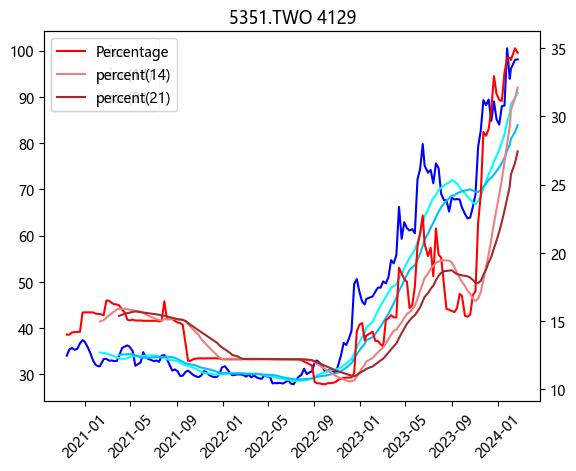

[*********************100%%**********************]  1 of 1 completed


          資料日期  >1000張大股東持有百分比    收盤價     mean14     mean21    price14  \
120 2023-03-17           15.21   51.0  13.675714  12.690476  47.678571   
121 2023-03-24           15.43   54.7  14.001429  12.926190  48.767857   
122 2023-03-31           15.27   54.0  14.292143  13.151429  49.085714   
123 2023-04-07           15.27   55.8  14.365000  13.369048  49.457143   
124 2023-04-14           18.91   66.2  14.663571  13.756667  50.771429   
125 2023-04-21           18.48   59.3  14.922143  14.120476  51.739286   
126 2023-04-28           18.08   62.9  15.244286  14.464762  53.010714   
127 2023-05-05           17.88   61.6  15.526429  14.799048  54.103571   
128 2023-05-12           15.95   61.1  15.650000  15.040952  55.121429   
129 2023-05-19           16.15   61.4  15.835714  15.276667  56.089286   
130 2023-05-26           17.51   60.5  16.118571  15.431905  56.928571   
131 2023-06-02           20.47   72.1  16.630714  15.705238  58.596429   
132 2023-06-09           21.45   74.4 

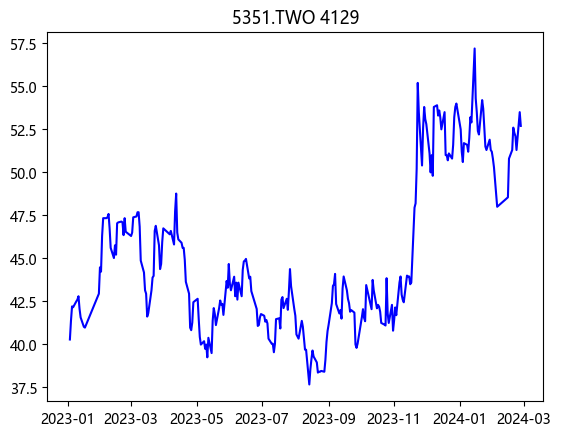

In [72]:
# ingredient
import requests
import pandas as pd
import yfinance as yf
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from datetime import datetime
import json
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # Set font to SimHei (a Chinese font)
plt.rcParams['axes.unicode_minus'] = False  # Ensure that minus signs (-) are displayed correctly for negative numbers
def plot_1000(stock_code, stock, a=3, b=9, print_db = False):
    
    
    url = f"https://norway.twsthr.info/StockHolders.aspx?stock={stock}"
    c = requests.get(url)
    soup = BeautifulSoup(c.text, "lxml")
    ds = soup.find_all("tr", {"class":"lDS"})
    ls = soup.find_all("tr", {"class":"lLS"})

    title = []
    date_ds = []
    date_ls = []
    price_ds = []
    price_ls = []
    percentage_ls = []
    percentage_ds = []
    total = 166 + 1
    total_ds = 83+1
    total_ls = 83

    for cc, i in enumerate(ds):
        for q, k in enumerate(i):
            if cc != 0:
                if q == 2:
                    date_str = k.text[:-1]
                    date_ds.append(f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}")
                if q == 13:
                    percentage_ds.append(k.text)
                if q == 14:
                    price_ds.append(k.text)

            else:
                if q in [2, 13, 14]:
                    title.append(k.text)
        if cc >= total_ds + 1:
            break

    for cc, i in enumerate(ls):
        for q, k in enumerate(i):
            if q == 2:
                date_str = k.text[:-1]
                date_ls.append(f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}")
            if q == 13:
                percentage_ls.append(k.text)
            if q == 14:
                price_ls.append(k.text)
        if cc >= total_ds + 1:
            break
    final_per = []
    final_pri = []
    final_dat = []
    for i in range(len(date_ds)): # 85 
        final_per.append(percentage_ds[i])
        final_per.append(percentage_ls[i])
        final_pri.append(price_ds[i])
        final_pri.append(price_ls[i])
        final_dat.append(date_ds[i])
        final_dat.append(date_ls[i])

    dates = [datetime.strptime(date, "%Y-%m-%d") for date in final_dat]

    # Convert values to float
    values = [float(value) for value in final_pri]
    percenta = [float(value) for value in final_per]


    c_name_a = f"mean{a}"
    c_name_b = f"mean{b}"
    p_name_a = f"price{a}"
    p_name_b = f"price{b}"
    if len(final_per) == len(final_pri) == len(final_dat):
        df = pd.DataFrame({title[0]:dates[::-1], 
                        title[1]:percenta[::-1],
                        title[2]:values[::-1]})
        
        df[c_name_a] = df[title[1]].rolling(a).mean()
        df[c_name_b] = df[title[1]].rolling(b).mean()
        df[p_name_a] = df[title[2]].rolling(a).mean()
        df[p_name_b] = df[title[2]].rolling(b).mean()
        fig, ax = plt.subplots()
        ax.plot(dates[::-1], values[::-1], color = "b", label='Price')
        ax.plot(dates[::-1], df[p_name_a], color = "aqua", label=f'price({a})')
        ax.plot(dates[::-1], df[p_name_b], color = "deepskyblue", label=f'price({b})')  
        ax1 = ax.twinx()

        ax1.plot(dates[::-1], percenta[::-1], color = "r", label='Percentage')
        ax1.plot(dates[::-1], df[c_name_a], color = "lightcoral", label=f'percent({a})')
        ax1.plot(dates[::-1], df[c_name_b], color = "brown", label=f'percent({b})')

        
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
        ax1.legend()
        plt.title(f"{stock_code} {stock}")
        plt.show()
        s = yf.download(stock_code, start="2023-01-01")

        plt.plot(s['Close'], color='b')
        plt.title(f"{stock_code} {stock}")
    if print_db:
        print(df.tail(50))


# with open("../../Database/TW/TW50/TW50.json", encoding="utf-8") as f:
#     dicts = json.load(f)

# for key, value in dicts.items():
#     plot_1000(value, key, a=14, b=21)

plot_1000("5351.TWO", "4129", 14, 21, True)

In [ ]:
import yfinance as yf
a = yf.download()

In [134]:
# 台股列表
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from fake_useragent import UserAgent

import psycopg2
from sqlalchemy import create_engine
from datetime import datetime

# 抓取股票資訊
url = "https://histock.tw/stock/rank.aspx?p=all"
user_agent = UserAgent()
headers = {'user-agent': user_agent.random}

# 獲取 html 資訊
res = requests.get(url, headers = headers)
tmp = BeautifulSoup(res.text, 'lxml').select_one('#CPHB1_gv')
df = pd.read_html(tmp.prettify())[0]
# 優化一下欄位名稱
df.columns = ['stock_no', 'stock_name', 'price', 'ud', 'udp', 'ud_w', 'amp','open', 'high', 'low', 'price_y', 'vol', 'vol_p']
df[df["price"] > 10]

,stock_no,stock_name,price,ud,udp,ud_w,amp,open,high,low,price_y,vol,vol_p
0,3661,世芯-KY,3900.00,▼-115.00,-2.86%,-4.41%,6.72%,4145.00,4170.00,3900.00,4015.00,2028,79.092
1,3529,力旺,2755.00,▼-90.00,-3.16%,-4.01%,5.45%,2895.00,2900.00,2745.00,2845.00,782,21.544
2,5274,信驊,2660.00,--,--,-12.36%,4.14%,2720.00,2770.00,2660.00,2660.00,1055,28.063
3,3008,大立光,2545.00,▲15.00,+0.59%,6.26%,1.98%,2550.00,2565.00,2515.00,2530.00,783,19.927
4,5269,祥碩,2280.00,▲115.00,+5.31%,13.72%,4.62%,2190.00,2285.00,2185.00,2165.00,1847,42.112
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102,4406,新昕纖,10.15,--,--,0.00%,1.48%,10.05,10.20,10.05,10.15,9,0.001
2103,5531,鄉林,10.15,▼-0.15,-1.46%,-3.33%,3.50%,10.35,10.35,9.99,10.30,1609,0.163
2104,5512,力麒,10.10,▼-0.15,-1.46%,-0.98%,2.44%,10.35,10.35,10.10,10.25,3283,0.332
2105,2537,聯上發,10.05,▲0.20,+2.03%,-4.74%,2.94%,9.87,10.10,9.81,9.85,3611,0.363
